In [ ]:
#list of imports
import pandas as pd
import numpy as np
import math
from datetime import datetime

import urllib.request
import tarfile

from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore') 

In [ ]:
#reading in the dataframe

url = "https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz"
filename, headers = urllib.request.urlretrieve(url, filename="latestdata.tar.gz")
 
if filename.endswith("tar.gz"): 
  tar = tarfile.open(filename, "r:gz") 
  tar.extractall() 
  tar.close() 
elif filename.endswith("tar"): 
  tar = tarfile.open(filename, "r:") 
  tar.extractall() 
  tar.close()

In [ ]:
#minor edits to dataset 

df = pd.read_csv(filename, header=1)
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

#remiving usless data
del df["city"]
del df["country"]
del df["province"]
del df["ID"]
del df["geo_resolution"]
del df["lives_in_Wuhan"]
del df["travel_history_dates"]
del df["travel_history_binary"]
del df["travel_history_location"]
del df["reported_market_exposure"]
del df["additional_information"]
del df["chronic_disease"]
del df["source"]
del df["admin3"]
del df["admin2"]
del df["admin1"]
del df["country_new"]
del df["admin_id"]
del df["data_moderator_initials"]
del df["date_death_or_discharge"]
del df["location"]
del df["sequence_available"]
del df["notes_for_discussion"]

#altering the dataframe
df = df[df['date_confirmation'].notna()]
df = df[df['age'].notna()]
df = df[df['sex'].notna()]
df = df[df['latitude'].notna()]
df = df[df['longitude'].notna()]
df = df[df['outcome'].notna()]

size = df.shape
DEGREE = 4
TRAIN_ON = 0.7
base_date = "6.6.2019"
print(df.count())

age                        33531
sex                        33531
latitude                   33531
longitude                  33531
date_onset_symptoms         3495
date_admission_hospital      243
date_confirmation          33531
symptoms                     177
chronic_disease_binary     33531
outcome                    33531
dtype: int64


In [ ]:
#function to convert dd/mm/yyyy into a single integer
def to_seconds(date, base_date = base_date):
    #initialize base datetime
    base = pd.DataFrame(np.array([[base_date]*date.size]).T)
    base = pd.to_datetime(base[0], dayfirst = True)

    #initialize the 2 date datetime columns
    date = date.reset_index(drop=True)
    cols = date.str.split('-',expand = True)
    cols[1] = cols[1].fillna(cols[0])
    start = pd.to_datetime(cols[0], dayfirst=True)
    end = pd.to_datetime(cols[1], dayfirst=True)

    #get median date between 2 columns
    day_diff = end-start
    date = start+(day_diff/2)

    #get difference between date and base and convert to seconds
    days = date - base
    seconds = days.dt.total_seconds().to_frame()

    return seconds

In [ ]:
#graphing function
def graph(y_pred):
  y_pred = pd.DataFrame(y_pred)
  y_pred.rename(columns={0: 'outcome'}, inplace=True)
  fig, ax = plt.subplots()
  sns.countplot(x = "outcome", data = y_pred, order=y_pred["outcome"].value_counts().iloc[:2].index)
  ax.set_xlabel("outcome",fontsize=17);
  plt.show()

In [ ]:
#normalise the outcome to 1's and 0's
def sheikhize(dfi):
    arr = [1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1]
    all = ['Hospitalized','Recovered','Deceased','recovered','died','Under treatment','Receiving Treatment','Alive','discharge','stable','stable condition','https://www.mspbs.gov.py/covid-19.php','discharged','death','Stable','Dead','Migrated_Other','Migrated','Discharged from hospital','Death','Died','released from quarantine','dead','severe','recovering at home 03.03.2020','critical condition, intubated as of 14.02.2020','Discharged','not hospitalized','treated in an intensive care unit (14.02.2020)','Symptoms only improved with cough. Currently hospitalized for follow-up.','severe illness','Critical condition','critical condition','unstable']
    outcome = (df["outcome"])

    for idx, i in enumerate(arr):
        outcome.replace(to_replace = all[idx], value = arr[idx],inplace=True)
    
    outcome = outcome.to_frame()
    outcome = outcome[outcome.outcome != 'NaN']
    return outcome

In [ ]:
#get the y data to be predicted
def get_y(df):
    outcome = sheikhize(df["outcome"])
    return outcome

In [ ]:
#get the x data for learning, and focused feature selection on each of the data points
def get_x(df):
    
    age = df["age"]
    age = age.str.split('-',expand = True).drop([1],axis = 1).squeeze()
    age = age.fillna(30)
    
    sex = df["sex"]
    sex = pd.get_dummies(sex,dummy_na = True)
    sex = sex["female"]*2 + sex["male"]
    sex = sex.to_frame()
    sex = sex.rename(columns={0: "sex"})
    sex = sex.fillna(0)
    
    latitude = df["latitude"].fillna(0)
    longitude = df["longitude"].fillna(0)
    
    date_onset_symptoms = df["date_onset_symptoms"].fillna(base_date)
    #date_onset_symptoms = to_seconds(date_onset_symptoms)

    date_admission_hospital = df["date_admission_hospital"].fillna(base_date)
    #date_admission_hospital = to_seconds(date_admission_hospital)
                                           
    symptoms = df["symptoms"].fillna(0)
    symptoms = pd.get_dummies(symptoms,dummy_na = True)
    symptoms = (symptoms.iloc[:,-1:] * -1 + 1)
    symptoms.columns = [*symptoms.columns[:-1], 'symptoms']

    chronic_disease_binary = df["chronic_disease_binary"].fillna(0)
    chronic_disease_binary = pd.get_dummies(chronic_disease_binary)
    chronic_disease_binary = chronic_disease_binary.drop([0], axis =1)
    chronic_disease_binary = chronic_disease_binary.rename(columns={1: "chronic_disease_binary"})
    
    x = pd.concat([age,sex,latitude,longitude,symptoms,chronic_disease_binary], axis=1)

    return x

In [ ]:
x = get_x(df)
y = get_y(df)

#split x and y into test and train
x_train = x.iloc[:int(size[0] * TRAIN_ON + 0.5)]
y_train = y.iloc[:int(size[0] * TRAIN_ON + 0.5)]
x_test = x.iloc[int(size[0] * TRAIN_ON + 0.5):]
y_test = y.iloc[int(size[0] * TRAIN_ON + 0.5):]

y_test.reset_index(drop=True, inplace=True)

In [ ]:
def bayesian(x_train,y_train, x_test, y_test,d):
    
    x_train = PolynomialFeatures(degree=d, include_bias=False).fit_transform(x_train)
    x_test = PolynomialFeatures(degree=d, include_bias=False).fit_transform(x_test)
    
    model = BayesianRidge().fit(x_train, y_train)

    y_pred = model.predict(x_test)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        corr = matthews_corrcoef(y_pred.round(), y_test.round())

    r2 = r2_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred.round())
    return y_pred, corr, r2, acc

[ 1.00025757  1.00252134  0.99038431 ... -0.15705962 -0.52044875
  0.49212848]
0.39213862037868014
0.2114410341569536
0.9361765583059947


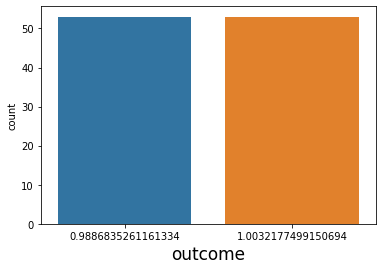

In [ ]:
y_pred,corr,r2, acc = bayesian(x_train,y_train, x_test, y_test,DEGREE)
print(y_pred)
print(corr)
print(r2)
print(acc)
graph(y_pred)

In [ ]:
def lr(x_train,y_train, x_test, y_test):
    sc_X = StandardScaler()

    x_train = sc_X.fit_transform(x_train)

    x_test = sc_X.transform(x_test)

    lr = LogisticRegression()

    lr.fit(x_train, y_train)

    y_pred = lr.predict(x_test)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        corr = matthews_corrcoef(y_pred.round(), y_test.round())

    r2 = r2_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    return y_pred, corr, r2, acc

[1 1 1 ... 0 1 1]
0.08643943010350438
-0.07115823111206465
0.9322994333432747


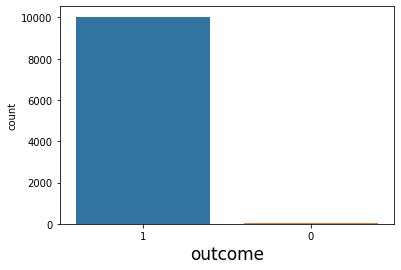

In [ ]:
y_pred,corr,r2, acc = lr(x_train,y_train, x_test, y_test)
print(y_pred)
print(corr)
print(r2)
print(acc)
graph(y_pred)

In [ ]:
def K_Neighbor(x_train,y_train, x_test, y_test):
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    y_train = (y_train).astype(int)

    kn = KNeighborsClassifier(n_neighbors=16)

    model = kn.fit(x_train, y_train)
    y_pred = model.predict(x_test)
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        corr = matthews_corrcoef(y_pred.round(), y_test.round())

    r2 = r2_score(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    return y_pred, corr, r2, acc

[1 1 1 ... 0 0 0]
0.43575942057709227
-0.3086690870561495
0.9172880007953077


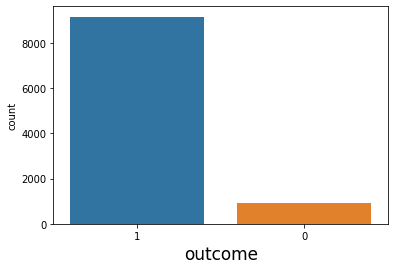

In [ ]:
y_pred,corr,r2, acc = K_Neighbor(x_train,y_train, x_test, y_test)
print(y_pred)
print(corr)
print(r2)
print(acc)
graph(y_pred)